In [1]:
import tomotopy as tp
import pandas as pd
import numpy as np
import sys
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re

### 1. Load the model and the abstracts file 

In [4]:
model = tp.LDAModel.load("lda_model150.bin")

In [3]:
data = pd.read_csv("abstracts_eng.csv")
collection = list(data['abstract'])

In [5]:
data.head(3)

,abstract,id,title
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz
2,An analysis of a 15th century Hebrew translati...,192001.0,Mordekhai Finzi’s Translation of Maestro Dardi...


In [10]:
# Example collection
toy_collection = ['hello hi I am a Data Science STUDENT here with Giulia and Andreas!U.S.A, United States of AMerica dixterochlomaterine hreoihso my dog ran away yesterday?! I will fly, to space tomorrow...',
                  'space tomorrow space tomorrow if the dog ran away fly to space',
                  ' fly to space  with my dog ran away']

### 2. Pre-process the text

The pre-processing comprises 2 steps: 
- tokenisation, stopwords-removal, stemming (optional), lemmatizing(optional)
- ngrams modeling (bigrams & trigrams supported)

Note: the first step is only dependent on a single input document, while ngrams modeling depends on the whole collection

In [6]:
# Step 1
word_stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
stop_words = stopwords.words('english')
def normalisation(document, stemming = True, lemmatising = True, min_word_len = 3):
    tokens = gensim.utils.simple_preprocess(str(document), deacc=True, max_len = sys.maxsize)
    cleaned = [word for word in tokens if word not in stop_words]
    if stemming:
        cleaned = [word_stemmer.stem(word) for word in cleaned]
    if lemmatising:
        cleaned = [lemmatiser.lemmatize(word) for word in cleaned]
    cleaned = [word for word in cleaned if (min_word_len<=len(word))]
    return cleaned

In [7]:
# Step 2
def ngram(cleaned_docs, do_trigram = True, min_count_bigram = 5, threshold_bigram = 50, min_count_trigram = 5, threshold_trigram=50):
    #Bigrams
    bigram = gensim.models.Phrases(cleaned_docs, min_count= min_count_bigram, threshold=threshold_bigram) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    output = [bigram_mod[doc] for doc in cleaned_docs]
    #Trigrams
    if do_trigram:
        trigram = gensim.models.Phrases(output, min_count= min_count_trigram, threshold=threshold_trigram) 
        trigram_mod = gensim.models.phrases.Phraser(trigram)
        output = [trigram_mod[doc] for doc in output]
    return output

In [11]:
# try out on toy collection
toy_normalised = [normalisation(text, lemmatising = True, stemming = True, min_word_len = -1) for text in toy_collection]

In [9]:
# run on true collection
normalised = [normalisation(doc) for doc in collection]

### 3. Extract topics for each document 


In [24]:
def get_top_topics(document, model, min_score=0.8):
    """ 
    Extracting top n topics for each document. 
    Selects the n most likely topics whose p(topic|document) sum to min_score.
    """
    # inserting the document in the model
    new_doc = model.make_doc(document)
    _,_ = model.infer(new_doc)
    # ordering from most probable topic to least one 
    dist = new_doc.get_topic_dist()
    indices = np.flip(np.argsort(dist))
    score = 0
    indices_kept = []
    probs_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        indices_kept.append(index)
        probs_kept.append(dist[index])
    return list(zip(indices_kept, probs_kept))

In [27]:
# trying on toy collection
get_top_topics(toy_normalised[0], model, 0.5)

[(11, 0.252124), (18, 0.13604221), (73, 0.1304265)]

In [28]:
# extracting topics for the original collection
docs2topics = [get_top_topics(doc, model) for doc in normalised]

In [29]:
# enriching original dataframe with the topics list x document 
# Note: the following command will only work if the order of documents is the same for the collection and the docs-topics list
enriched = data
enriched["topics"] = docs2topics

In [30]:
enriched.head(3)

,abstract,id,title,topics
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"[(105, 0.48136905), (92, 0.2269906), (62, 0.09..."
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz,"[(105, 0.501014), (44, 0.14082292), (13, 0.111..."
2,An analysis of a 15th century Hebrew translati...,192001.0,Mordekhai Finzi’s Translation of Maestro Dardi...,"[(101, 0.2754092), (112, 0.27519676), (105, 0...."


In [33]:
# exploding the dataframe (one row for each document-topic pair)
enriched=enriched.explode("topics")
enriched.columns = ["abstract","publication_id","publication_title","topic"]

In [34]:
enriched.head(3)

,abstract,publication_id,publication_title,topic
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(105, 0.48136905)"
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(92, 0.2269906)"
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(62, 0.096369736)"


In [37]:
# separate topic id and probability

enriched[["topic_id","topic_probability"]] = pd.DataFrame(enriched["topic"].tolist(), 
                                                          index=enriched.index)
enriched.head()

,abstract,publication_id,publication_title,topic,topic_id,topic_probability
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(105, 0.48136905)",105,0.481369
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(92, 0.2269906)",92,0.226991
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"(62, 0.096369736)",62,0.096370
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz,"(105, 0.501014)",105,0.501014
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz,"(44, 0.14082292)",44,0.140823


In [39]:
enriched = enriched.drop(["topic"], axis = 1)
enriched.head(3)

,abstract,publication_id,publication_title,topic_id,topic_probability
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,105,0.481369
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,92,0.226991
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,62,0.096370


In [52]:
# issue: quotes need to be escaped in neo4j
# the following function helps us avoid errors when importing

def add_quote(abstract):
    if isinstance(abstract, str):
        abstract = abstract.replace('\\"', '""')
        return abstract.replace('"', '""')

enriched["abstract"] = enriched["abstract"].apply(add_quote)

In [53]:
# save to .csv 
file_name="abstract+topic.csv"
enriched.to_csv(file_name,index=False)

### 4. Extract words for each topic

In [45]:
def get_top_words(topic, model, min_score=0.8):
    """
    Extracting top n words for each document. 
    Selects the n most likely words whose p(word|topic) sum to min_score.
    """
    dist = model.get_topic_word_dist(topic)
    indices = np.flip(np.argsort(dist))
    score = 0
    word_kept = []
    word_prob_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        word_kept.append(model.used_vocabs[index])
        word_prob_kept.append(dist[index])
    return list(zip(word_kept, word_prob_kept))

In [46]:
# trying it out
get_top_words(2, model, 0.25)

[('tc', 0.048273724),
 ('spectrum', 0.043341003),
 ('peak', 0.025371805),
 ('ce', 0.020791419),
 ('ab', 0.014801687),
 ('spectral', 0.0105736405),
 ('band', 0.010221303),
 ('deriv', 0.009164291),
 ('sa', 0.008811954),
 ('transit', 0.0070502684),
 ('experi', 0.0070502684),
 ('signal', 0.006697931),
 ('inclus', 0.006697931),
 ('cen', 0.006697931),
 ('atc', 0.006697931),
 ('pin', 0.006697931),
 ('nm', 0.006345594),
 ('specif_heat', 0.006345594)]

In [47]:
num_topics = 150

In [48]:
topics2words = [get_top_words(i, model, min_score=0.25) for i in range(num_topics)]

In [49]:
# creating new topic dataframe
topics_df = pd.DataFrame({"TopicID":range(num_topics),"TopicWords":topics2words})

In [50]:
topics_df.head(3)

,TopicID,TopicWords
0,0,"[(flow, 0.06010573), (fluid, 0.017224967), (tr..."
1,1,"[(frequenc, 0.05785778), (nois, 0.028391361), ..."
2,2,"[(tc, 0.048273724), (spectrum, 0.043341003), (..."


In [51]:
# save to .csv 
file_name="topics.csv"
topics_df.to_csv(file_name,index=False)

### Export to Neo4j

Topic nodes: 
- TopicID (long)
- Words (list(str)) 
<br>
<br>

        #Adding abstracts to existing publications
        #LOAD CSV WITH HEADERS FROM "file:///abstract+topic.csv" AS line
        #WITH line WHERE line.publication_id IS NOT NULL
        #MATCH (publication:Publication {title: line.publication_title})
        #SET publication.abstract = line.abstract
        
        #Defining the topic nodes
        CREATE CONSTRAINT ON (c:Topic) ASSERT c.ID IS UNIQUE;
        
        #Loading the topic nodes 
        LOAD CSV WITH HEADERS FROM "file:///topics.csv" AS line
        WITH line where line.TopicID IS NOT NULL
        MERGE (t: Topic {ID: line.TopicID})
        SET t.words= line.TopicWords;
        
        #Loading document<->topic relationships
        LOAD CSV WITH HEADERS FROM "file:///abstract+topic.csv" AS line
        MATCH (p:Publication {title: line.publication_title}),
               (t:Topic {ID:line.topic_id})
        MERGE (p)-[r:IS_ABOUT {weight: round(1000 * toFloat(line.topic_probability)) / 1000}]->(t);
        

### 5. Visualizations

Here we use the docs2topics and topics2words data extracted before to get nice visualisations of our collection 

In [46]:
topic_df = pd.read_csv("topics.csv")
topic_df.head()

,TopicID,TopicWords
0,0,"['flow', 'fluid', 'transport', 'pressur', 'vel..."
1,1,"['frequenc', 'nois', 'signal', 'oscil', 'pul',..."
2,2,"['tc', 'spectrum', 'peak', 'ce', 'ab', 'spectr..."
3,3,"['integr', 'comput', 'loop', 'order', 'correct..."
4,4,"['channel', 'capac', 'receiv', 'sourc', 'input..."


In [71]:
def process_topic(ls):
    return ls.strip("][").replace("'","").split(', ')

In [74]:
topics2words = list(topic_df["TopicWords"].apply(process_topic))

In [40]:
# topic sparsity measure of our documents
docs2num_topics = [len(ts) for ts in docs2topics]

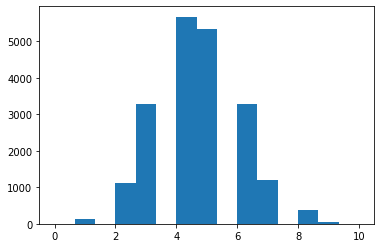

In [57]:
import matplotlib.pyplot as plt
h = plt.hist(docs2num_topics, bins=15, range=(0,10))
plt.show(h)

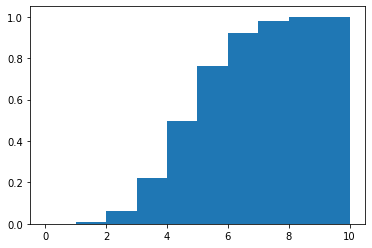

In [58]:
h = plt.hist(docs2num_topics, bins=10, range=(0,10), density=True, cumulative=True)
plt.show(h)

In [77]:
# word sparsity measure of our topics
topics2num_words = [len(ts) for ts in topics2words]

In [78]:
set(topics2num_words)

{2,
 3,
 5,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45}

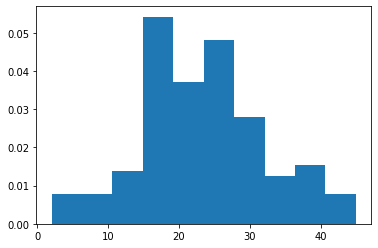

In [80]:
import matplotlib.pyplot as plt
h2 = plt.hist(topics2num_words, density = True)
plt.show(h2)

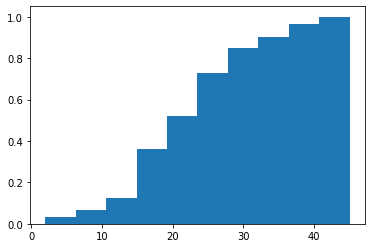

In [81]:
h3 = plt.hist(topics2num_words, density=True, cumulative=True)
plt.show(h3)